In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, InputLayer, GlobalAveragePooling2D

In [2]:
songs = ['Frozen', 'Hakuna', 'Potter', 'Mamma', 'Panther', 'Rain', 'Showman', 'StarWars']

### Load and prepare the data for training

In [3]:
def load_data():
    X = np.load('mfcc_data.npy')
    y = np.load('labels.npy')

    return X, y

X, y = load_data() 

X = X.reshape(-1, X.shape[1], X.shape[2], 1)

y_encoded = LabelEncoder().fit_transform(y)
y_onehot = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=69)

print(X_train.shape)
print(y_train.shape)

(3848, 128, 603, 1)
(3848, 8)


### Model: AlexNet with added Batch Normalization

In [4]:
model = Sequential([
    InputLayer(input_shape=(X.shape[1], X.shape[2], 1)),

    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(4096, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    # Output Layer
    Dense(len(songs), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 149, 96)       11712     
                                                                 
 batch_normalization (BatchN  (None, 30, 149, 96)      384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 149, 96)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 74, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 74, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 74, 256)      1

### Training

In [5]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
97/97 [==============================] - 12s 75ms/step - loss: 2.3297 - accuracy: 0.3879 - val_loss: 22.5208 - val_accuracy: 0.1896
Epoch 2/50
97/97 [==============================] - 7s 68ms/step - loss: 1.5195 - accuracy: 0.5851 - val_loss: 1.5111 - val_accuracy: 0.5688
Epoch 3/50
97/97 [==============================] - 7s 68ms/step - loss: 1.1435 - accuracy: 0.7040 - val_loss: 2.2294 - val_accuracy: 0.5026
Epoch 4/50
97/97 [==============================] - 7s 69ms/step - loss: 0.8288 - accuracy: 0.7706 - val_loss: 1.1817 - val_accuracy: 0.7299
Epoch 5/50
97/97 [==============================] - 7s 69ms/step - loss: 0.7285 - accuracy: 0.7992 - val_loss: 2.4339 - val_accuracy: 0.5831
Epoch 6/50
97/97 [==============================] - 7s 69ms/step - loss: 0.4993 - accuracy: 0.8528 - val_loss: 2.4731 - val_accuracy: 0.5896
Epoch 7/50
97/97 [==============================] - 7s 69ms/step - loss: 0.4159 - accuracy: 0.8678 - val_loss: 1.1170 - val_accuracy: 0.7740
Epoch 8/50


### Plot loss over epochs

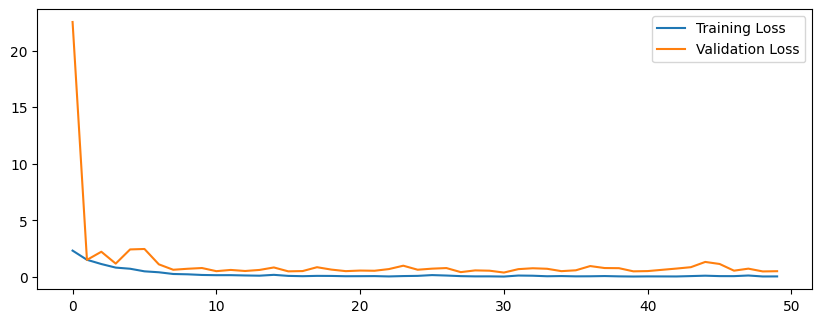

In [6]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')


### Plot accuracy over epochs

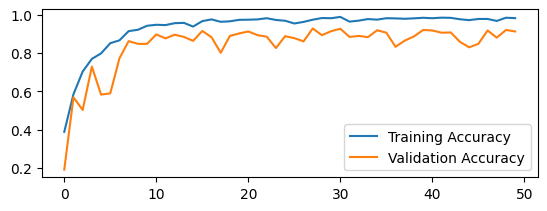

In [7]:
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

Looking at the plots, from after 10-20 epochs, the model loss and accuracy seem to have stabilized, which means we can stop training at that point.

### Evaluate on test data

In [8]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 1s 30ms/step - loss: 0.3482 - accuracy: 0.9387


[0.34823209047317505, 0.9386694431304932]

### Confusion matrix

In [9]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

tf.math.confusion_matrix(y_true, y_pred)

31/31 [==============================] - 1s 30ms/step


<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[104,   3,   2,   0,   1,   2,   2,   0],
       [  0, 117,   0,   0,   1,   1,   3,   1],
       [  1,   2, 120,   0,   0,   0,   2,   1],
       [  1,   0,   0, 110,   1,   4,   0,   0],
       [  0,   0,   1,   0, 129,   3,   0,   1],
       [  1,   2,   0,   3,   0, 103,   2,   0],
       [  0,   3,   0,   0,   1,   3, 106,   0],
       [  0,   4,   0,   2,   1,   2,   2, 114]])>